# Iterative Hard Thresholding

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from PIL import Image
import pywt
import pywt.data
from utils_wavelet import *
import scipy.stats as stats

In [7]:
def fun_conv(A,B):
    conv = signal.fftconvolve(A,B,mode='same')
    return conv

def naive_conv(A,B):
    C = np.zeros(len(A))
    for i in range(len(A)):
        C[i] = np.sum(A*np.roll(np.roll(np.flip(B),1),i))
    return C

def manual_conv(A,B):
    C = np.zeros(len(A))
    for m in range(len(A)):
        for i in range(len(B)):
            C[m] += A[i]*B[m-i]
    return C

def fun_auto(A):
    auto = signal.fftconvolve(A,np.flip(A),mode='same')
    return auto

def imshowArray(arr):
    plt.imshow((arr,arr))
    plt.ylim([0,1])

def npArray2arrayList(a_vector):
    fake_a_coef = pywt.wavedec(a_vector,'db1')
    a_vector_array = vec2arrayList(a_vector,fake_a_coef)
    return a_vector_array

def npMatrix2arrayList(a_matrix):
    fake_a_coef = pywt.wavedec2(a_matrix,'db1')
    a_vector_array = vec2arrayList(a_matrix.flatten(),fake_a_coef)
    return a_vector_array

def L0norm(vector,zero=1e-5):
    return vector[np.where(abs(vector)>zero)].size

global_factor = 4

def image_open(location):
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

def image_open_newsize(location,newsize):
    image_im = Image.open(location)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

def psi_op(alpha):
    return pywt.waverec2(npMatrix2arrayList(alpha),'db1')

def psi_adj_op(x_signal):
    return arrayList2vec(pywt.wavedec2(x_signal,'db1'))

def flipNroll(matrix):
    return np.roll(np.flip(matrix),(-1, -1), axis=(0, 1))

def inf_norm(matrix):
    return max(abs(row.sum()) for row in matrix)

wtype = 'db1'

def waverec2fromArray(my_array):
    wdec = pywt.wavedec2(my_array,wavelet=wtype)
    wcoef, wslices = pywt.coeffs_to_array(wdec)
    my_coef = pywt.array_to_coeffs(my_array,wslices,'wavedec2')
    output = pywt.waverec2(my_coef,wtype)
    return output

def wavedec2toArray(my_array):
    output  = pywt.coeffs_to_array(pywt.wavedec2(my_array,wavelet=wtype))[0]
    return output

Size of the matrices

In [8]:
sx = 64
sy = 128

Image x (GT)

L0 = 1344


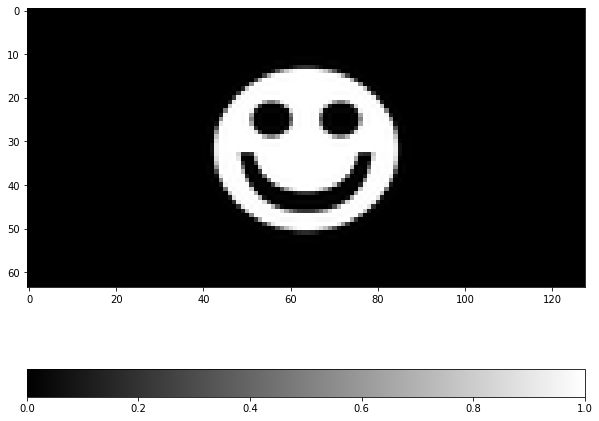

In [9]:
x_GT = image_open_newsize('images/face2.png',(sy,sx))/255

print('L0 =',L0norm(x_GT))

plt.figure(figsize=(10,10))
plt.imshow(x_GT,cmap='gray')
plt.colorbar(orientation='horizontal')
plt.show()

Sparse alpha

L0 alfa = 1477
Diff = -1.4487595497328474e-12


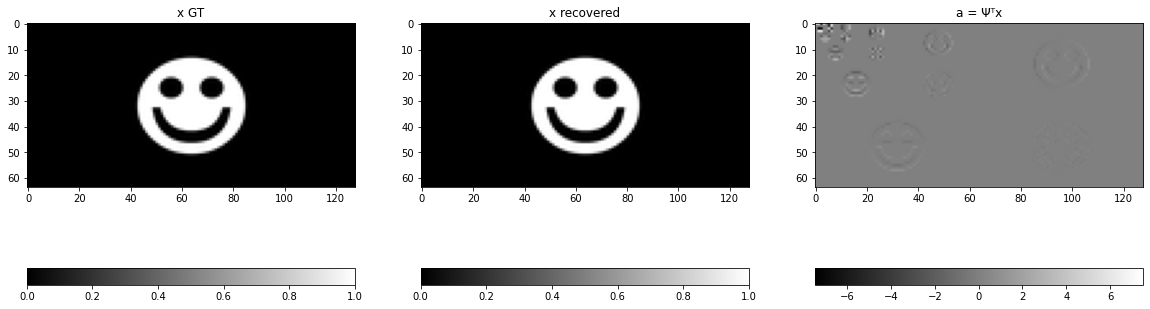

In [10]:
# fake_x_vector = np.ones((sx,sy))
# fake_coef = pywt.wavedec2(fake_x_vector,'db1')
# a_GT
# a_real_array = vec2arrayList(a_GT.flatten(),fake_coef) 

alfa = wavedec2toArray(x_GT)
L0alfa = L0norm(alfa)
print('L0 alfa =',L0alfa)
x_recovered = waverec2fromArray(alfa)


print('Diff =',np.sum(x_GT-x_recovered))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(x_GT,cmap='gray')
plt.colorbar(orientation='horizontal')
plt.title('x GT')
plt.subplot(1,3,2)
plt.imshow(x_recovered,cmap='gray')
plt.colorbar(orientation='horizontal')
plt.title('x recovered')
plt.subplot(1,3,3)
plt.imshow(alfa,cmap='gray')
plt.colorbar(orientation='horizontal')
plt.title('a = Ψᵀx')
plt.show()

Filter h

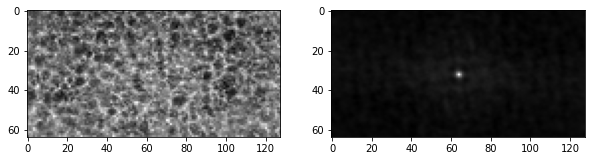

In [11]:
h = image_open_newsize('from_camera/test10/h.png',(sy,sx)) - image_open_newsize('from_camera/test10/h_black.png',(sy,sx))
h -= np.mean(h)
h /= np.linalg.norm(h)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(h,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(fun_auto(h),cmap='gray')
plt.show()

In [12]:
# #Dirac's delta
# h = np.zeros((sx,sy))
# h[math.floor(sx/2)-1,math.floor(sy/2)-1] = 1
# h[math.floor(sx/2),math.floor(sy/2)-1] = 1
# h[math.floor(sx/2)-1,math.floor(sy/2)] = 1
# h[math.floor(sx/2),math.floor(sy/2)] = 1

# #Gaussian disk
# # x=np.arange(sx)
# # y=np.arange(sy)
# # [xx,yy]=np.meshgrid(y,x)
# # mu_x = math.floor(sy/2)-1
# # mu_y = math.floor(sx/2)-1
# # sig = 1
# # h = np.exp(-((xx-mu_x)**2+(yy-mu_y)**2)/(2*sig**2) )*2

# print('sum =',np.sum(h))
# plt.figure(figsize=(10,4))
# plt.imshow(h,cmap='gray')
# plt.colorbar(orientation='vertical')
# plt.show()

Output y

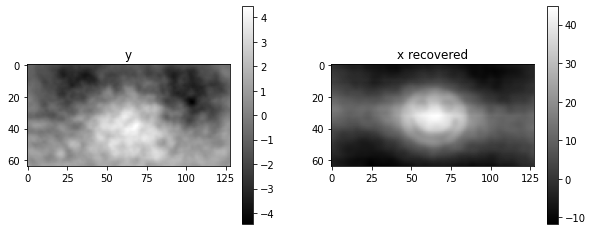

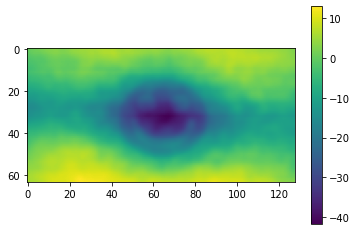

In [13]:
y = fun_conv(h,x_GT)
x_back = fun_conv(np.flip(h),y)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(y,cmap='gray')
plt.colorbar(orientation='vertical')
plt.title('y')
plt.subplot(1,2,2)
plt.imshow(x_back,cmap='gray')
plt.colorbar(orientation='vertical')
plt.title('x recovered')
plt.show()

plt.figure()
plt.imshow(y-x_back)
plt.colorbar()
plt.show()

IHTA

In [14]:
#stepsize
Ninf = inf_norm(np.fft.fft2(h))
mu = 0.5/(Ninf**2)

print(mu)


0.0005697867393481853


k ← 1
k ← 2
k ← 3
k ← 4
k ← 5
k ← 6
k ← 7
k ← 8
k ← 9
k ← 10
k ← 11
k ← 12
k ← 13
k ← 14
k ← 15
k ← 16
k ← 17
k ← 18
k ← 19
k ← 20
k ← 21
k ← 22
k ← 23
k ← 24
k ← 25
k ← 26
k ← 27
k ← 28
k ← 29
k ← 30
k ← 31
k ← 32
k ← 33
k ← 34
k ← 35
k ← 36
k ← 37
k ← 38
k ← 39
k ← 40
k ← 41
k ← 42
k ← 43
k ← 44
k ← 45
k ← 46
k ← 47
k ← 48
k ← 49
k ← 50
k ← 51
k ← 52
k ← 53
k ← 54
k ← 55
k ← 56
k ← 57
k ← 58
k ← 59
k ← 60
k ← 61
k ← 62
k ← 63
k ← 64
k ← 65
k ← 66
k ← 67
k ← 68
k ← 69
k ← 70
k ← 71
k ← 72
k ← 73
k ← 74
k ← 75
k ← 76
k ← 77
k ← 78
k ← 79
k ← 80
k ← 81
k ← 82
k ← 83
k ← 84
k ← 85
k ← 86
k ← 87
k ← 88
k ← 89
k ← 90
k ← 91
k ← 92
k ← 93
k ← 94
k ← 95
k ← 96
k ← 97
k ← 98
k ← 99
k ← 100
k ← 101
k ← 102
k ← 103
k ← 104
k ← 105
k ← 106
k ← 107
k ← 108
k ← 109
k ← 110
k ← 111
k ← 112
k ← 113
k ← 114
k ← 115
k ← 116
k ← 117
k ← 118
k ← 119
k ← 120
k ← 121
k ← 122
k ← 123
k ← 124
k ← 125
k ← 126
k ← 127
k ← 128
k ← 129
k ← 130
k ← 131
k ← 132
k ← 133
k ← 134
k ← 135
k ← 136
k ← 137
k ← 138
k ← 

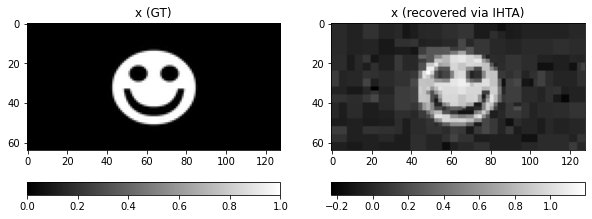

In [15]:
alfa_k = np.zeros(alfa.shape)
k = 0
s = 1000 #L0alfa
# mu = 1e-4
big = 100
plotting_threshold = np.array([])

while (k<s):
    plotting_threshold = np.append(plotting_threshold,big)
    if (big < 300):
        big += 1
    #gradient descent
    gradient = wavedec2toArray(fun_conv(np.flip(h),(y-fun_conv(h,waverec2fromArray(alfa_k)))))
    beta = alfa_k + mu*gradient

    #hard thresholding
    beta = beta.flatten()
    big_element = np.sort(abs(beta))[-big]   #The ht biggest elements
    beta[abs(beta)<big_element] = 0          #if (coef < ht_biggest_element): coef = 0            
    alfa_k = beta.reshape(alfa.shape)
    
    #next
    k += 1
    print('k ←',k)

a_IHTA = np.copy(alfa_k)
x_IHTA = waverec2fromArray(a_IHTA)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(x_GT,cmap='gray')
plt.title('x (GT)')
plt.colorbar(orientation="horizontal")
plt.subplot(1,2,2)
plt.imshow(x_IHTA,cmap='gray')
plt.title('x (recovered via IHTA)')
plt.colorbar(orientation="horizontal")
plt.show()

C:\Users\Usuari\AppData\Local\Temp\ipykernel_11212\416081105.py:48: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(orientation="horizontal")


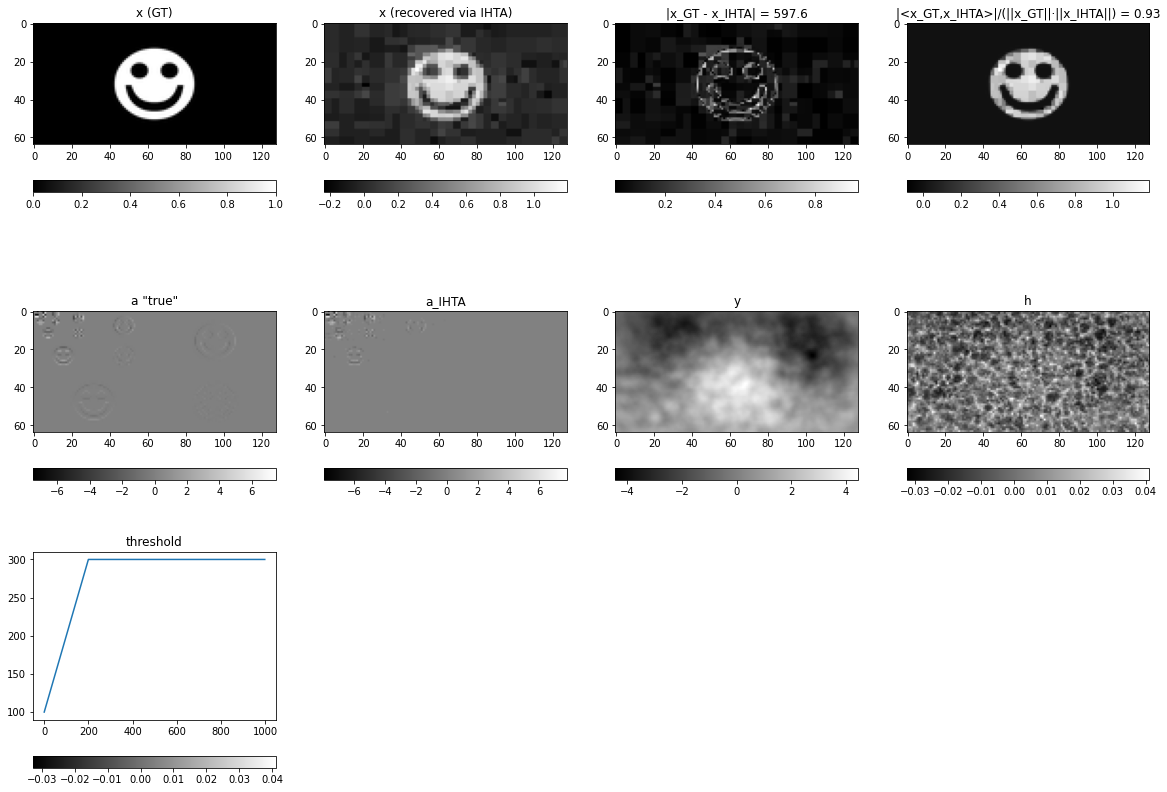

In [16]:
plt.figure(figsize=(20,15))

plt.subplot(3,4,1)
plt.imshow(x_GT,cmap='gray')
plt.title('x (GT)')
plt.colorbar(orientation="horizontal")


plt.subplot(3,4,2)
plt.imshow(x_IHTA,cmap='gray')
plt.title('x (recovered via IHTA)')
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,3)
plt.imshow(np.abs(x_GT-x_IHTA),cmap='gray')
plt.title('|x_GT - x_IHTA| = '+str(round(np.sum(np.abs(x_GT-x_IHTA)),2)))
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,4)
plt.imshow(x_GT*x_IHTA,cmap='gray')
error_pond = np.sum(x_GT*x_IHTA)/np.linalg.norm(x_GT)/np.linalg.norm(x_IHTA)
plt.title('|<x_GT,x_IHTA>|/(||x_GT||·||x_IHTA||) = '+str(round(error_pond,2)))
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,5)
plt.imshow(alfa,cmap='gray')
plt.title('a "true"')
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,6)
plt.imshow(a_IHTA,cmap='gray')
plt.title('a_IHTA')
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,7)
plt.imshow(y,cmap='gray')
plt.title('y')
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,8)
plt.imshow(h,cmap='gray')
plt.title('h')
plt.colorbar(orientation="horizontal")

plt.subplot(3,4,9)
plt.plot(plotting_threshold)
plt.title('threshold')

# plt.subplot(3,4,10)
# plt.plot(plotting_product,'-',label='product convergence')
# plt.plot(plotting_residue,'-',label='residual convergence')
# plt.legend()
# plt.title('convergence')

# plt.savefig('resultats/ihta_2d1.png', bbox_inches='tight')
plt.show()

FLIP

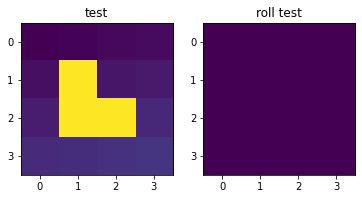

In [17]:
test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
test[1,1] = 100
test[2,1] = 100
test[2,2] = 100
# test = np.fft.fftshift(test)
# rtest = flipNroll(test)
rrtest = test[::-1, ::-1]


plt.figure()
plt.subplot(1,2,1)
plt.imshow(test)
plt.title('test')
plt.subplot(1,2,2)
plt.imshow(rrtest-np.flip(test))
plt.title('roll test')
plt.show()